# Adversarial Search: Playing Connect 4

Student Name: Blake William Gebhardt

I have used the following AI tools: Probably ChatGPT to help with syntax and logic errors. 

I understand that my submission needs to be my own work: BwG

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Initial State: We start with an empty Connect-4 board. According to the Connect-4 wikipedia (and the blurb above), the standard board is 7x6, but "size variations include 5×4, 6×5, 8×7, 9×7, 10×7, 8×8, Infinite Connect-Four, and Cylinder-Infinite Connect-Four." We'll keep it simple with the 7x6.

Actions: Players can select a column to drop their piece into, and the piece will now occupy the first open position in the column.

Transition Model: The result function updates the game board by placing the player's disc in the column that they pick and makes sure the piece moves to the first open spot. It then should make sure the turn swaps to the other player.

Goal State: The goal state is obviously a state that has 4 of my pieces in a row while also not having 4 opponent pieces in a row. The 4 in a row can be horizontal, vertical, or diagonal. It's also possible that the board fills up with no 4s in a row, which would be a tie. We obsiously want to work to make moves that get us closer to having 4 in a row while minimizing the length of connected pieces the opponent has.

How big is the state space? Give an estimate and explain it.

The state space of a 7x6 Connect 4 board is 4,531,985,219,092 total possible positions. I ripped this straight from the Wikipedia. There are 7x6 spaces (42 spaces). Each space can be empty, red, or yellow (3 choices), but there must be an equal amount of red/yellow or one more red than yellow. 3^42 is 1.0941899e+20, so it's definitely less than that. According to https://oeis.org/A212693, the sequence of valid boards after n-plays is as follows: 1, 7, 49, 238, 1120, 4263, 16422, 54859, 184275, 558186, 1662623, 4568683, 12236101, 30929111, 75437595, 176541259, 394591391, 858218743, 1763883894, 3568259802, 6746155945, 12673345045, 22010823988, 38263228189, 60830813459, 97266114959, 140728569039. The sum of these is 4,531,985,219,092.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

Minimax search will have to go through a huge game tree. It will roughly be 7^42, since there are 7 possible moves at every turn the player has.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [34]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

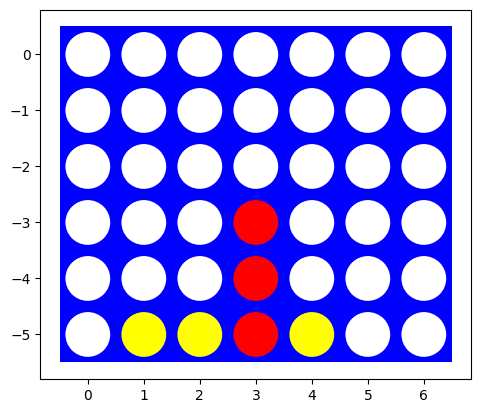

In [35]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [36]:
from scipy.signal import convolve2d
from timeit import default_timer as timer
import math

class HelperFunctions:
    @staticmethod
    def place(choice: int, board, player: int = None):
        theBoard = np.array(board).transpose()
        if player is None:
            arr_sum = theBoard.sum()
            if arr_sum <= 0:
                player = 1
            else:
                player = -1
        lst = theBoard[choice]
        gen = (len(lst) - 1 - i for i, v in enumerate(reversed(lst)) if v == 0)
        last_idx = next(gen, None)
        theBoard[choice][last_idx] = player
        return theBoard.transpose()

    @staticmethod
    def get_valid_moves(board):
        return [i for i, j in enumerate(board[0]) if j == 0]

    @staticmethod
    def to_move(board):
        theBoard = np.array(board)
        arr_sum = theBoard.sum()
        if arr_sum <= 0:
            player = 1
        else:
            player = -1
        return player

    @staticmethod
    def check_win(board):
        if len(HelperFunctions.get_valid_moves(board)) == 0:
            return None
        horizontal_kernel = np.array([[1, 1, 1, 1]])
        vertical_kernel = np.transpose(horizontal_kernel)
        diag1_kernel = np.eye(4, dtype=np.uint8)
        diag2_kernel = np.fliplr(diag1_kernel)
        detection_kernels = [horizontal_kernel, vertical_kernel, diag1_kernel, diag2_kernel]
        for kernel in detection_kernels:
            a = convolve2d(board, kernel, mode='valid')
            if (a == 4).any():
                return 1
            if (a == -4).any():
                return -1
        return 0

    @staticmethod
    def evaluate_board(board, player):
        try:
            return HelperFunctions.calc_utility(player, board) * 2, True
        except:
            horizontal_kernel = np.array([[1, 1, 1, 1]])
            vertical_kernel = np.transpose(horizontal_kernel)
            diag1_kernel = np.eye(4, dtype=np.uint8)
            diag2_kernel = np.fliplr(diag1_kernel)
            detection_kernels = [horizontal_kernel, vertical_kernel, diag1_kernel, diag2_kernel]
            utils = []
            for kernel in detection_kernels:
                a = convolve2d(board, kernel, mode='valid')
                if (a == (3 * player)).any():
                    times = np.count_nonzero(a == (3 * player))
                    utils += [0.5] * times
                if (a == (2 * player)).any():
                    times = np.count_nonzero(a == (2 * player))
                    utils += [0.25] * times
                if (a == (3 * player) * -1).any():
                    times = np.count_nonzero(a == (3 * player * -1))
                    utils += [-0.5] * times
                if (a == (2 * player) * -1).any():
                    times = np.count_nonzero(a == (2 * player * -1))
                    utils += [-0.25] * times

            seven_trap = np.array([
                [1, 1, 1],
                [0, 1, 0],
                [1, 0, 0]
            ])
            seven_kernels = [seven_trap]
            seven_kernels.append(np.array([
                [1, 1, 1],
                [0, 1, 0],
                [0, 0, 1]
            ]))
            seven_kernels = [np.flip(arr) for arr in seven_kernels]
            for kernel in seven_kernels:
                a = convolve2d(board, kernel, mode='valid')
                if (a == (5 * player)).any():
                    times = np.count_nonzero(a == (5 * player))
                    utils += [0.75] * times
                if (a == (5 * player * -1)).any():
                    times = np.count_nonzero(a == (5 * player * -1))
                    utils += [-0.75] * times

            if len(utils) != 0:
                return HelperFunctions.sigmoid(np.sum(utils)), False
            else:
                return 0, False

    @staticmethod
    def time_function(theFunc, *args):
        start = timer()
        theFunc(*args)
        print(f"{theFunc.__name__}: {(timer() - start) * 1000} ms")

    @staticmethod
    def calc_utility(player, board):
        winner = HelperFunctions.check_win(board)
        if len(HelperFunctions.get_valid_moves(board)) == 0:
            return 0
        if winner == 0:
            raise Exception("Tried to calculate the utility of non-terminal State")
        if winner == player:
            return 1
        else:
            return -1

    @staticmethod
    def sigmoid(x):
        return ((1 / (1 + math.e ** -x)) * 2) - 1


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [37]:
# Your code/ answer goes here.
import random
def random_player(board,player= None):
    try:
        return {"move":random.choice(HelperFunctions.get_valid_moves(board)),"value":0}
    except:
        return None

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [38]:
# Your code/ answer goes here.
def random_agents_environment(num_iters=1000):
    players = [1,-1]
    attempts = []
    for i in range(num_iters):
        board = empty_board()
        turn_num = 0
        while(HelperFunctions.check_win(board) == 0):
            print("Player",players[turn_num % len(players)],"Util for him:",HelperFunctions.evaluate_board(board,players[turn_num % len(players)]))
            # visualize(board)
            the_choice = random_player(board)
            if(the_choice is None): break
            else: the_choice = the_choice['move']
            turn = players[turn_num % len(players)]
            board = HelperFunctions.place(the_choice,board,player=turn)
            turn_num += 1
        # visualize(board)
        attempts.append({
            "turns_taken":turn_num,
            "winner":HelperFunctions.check_win(board)
        })
    return attempts
def print_results(attempts):
    p1_wins = len([val for val in attempts if val["winner"] == 1])
    p2_wins = len([val for val in attempts if val["winner"] == -1])
    ties = len([val for val in attempts if val["winner"] is None])
    turns = np.array([val["turns_taken"] for val in attempts]).mean()
    print(f'''
    Player 1 Wins: {p1_wins}
    Player 2 Wins: {p2_wins}
    Ties: {ties}
    Average Turns: {turns}''')
    
    


attempts = random_agents_environment(num_iters=1)

Player 1 Util for him: (0, False)
Player -1 Util for him: (0, False)
Player 1 Util for him: (0, False)
Player -1 Util for him: (0, False)
Player 1 Util for him: (-0.12435300177159614, False)
Player -1 Util for him: (0.0, False)
Player 1 Util for him: (-0.12435300177159614, False)
Player -1 Util for him: (0.0, False)
Player 1 Util for him: (-0.2449186624037092, False)
Player -1 Util for him: (0.12435300177159614, False)
Player 1 Util for him: (-0.2449186624037092, False)
Player -1 Util for him: (0.0, False)
Player 1 Util for him: (-0.12435300177159614, False)
Player -1 Util for him: (-0.12435300177159614, False)
Player 1 Util for him: (-0.12435300177159614, False)
Player -1 Util for him: (-0.2449186624037092, False)
Player 1 Util for him: (0.12435300177159614, False)
Player -1 Util for him: (-0.35835739835078595, False)
Player 1 Util for him: (0.35835739835078595, False)
Player -1 Util for him: (-0.703905603936621, False)
Player 1 Util for him: (0.5545997223493822, False)
Player -1 Util

It seems that Player 1 has a slight advantage when playing randomly. This is about expected, as generally going first in any game puts you at a significant advantage. Other than that, it's about evenly matched.

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points] 

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [39]:
# Your code/ answer goes here.
import sys

ITERATIONS = 0
DEBUG = False
def min_value(board,player,alpha,beta):
    global ITERATIONS
    global DEBUG
    ITERATIONS+=1
    # if DEBUG:
    #     print(f"IN MIN VALUE | Alpha: {alpha}, Beta: {beta}")
    # visualize(board)
    # print(f"In min iteration #{ITERATIONS}")
    # print(f"Calculating min value for {player} with board\n{board}\nIteration #{curr_iters}")
    try:
        return HelperFunctions.calc_utility(player,board),None
    except:
        v = float('inf')
        for action in HelperFunctions.get_valid_moves(board):
            v2,a2 = max_value(HelperFunctions.place(action,board),player,alpha,beta)
            if(v2 < v):
                v = v2
                move = action
                beta = min([beta,v])
            if v <= alpha:
                if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
                return v,move
        return v,move
def max_value(board,player,alpha,beta):
    global ITERATIONS
    # visualize(board)
    ITERATIONS+=1
    try:
        return HelperFunctions.calc_utility(player,board),None
    except:
        v = float('-inf')
        for action in HelperFunctions.get_valid_moves(board):
            v2,a2 = min_value(HelperFunctions.place(action,board),player,alpha,beta)
            if v2 > v:
                v = v2
                move = action
                alpha = max([alpha,v])
            if v >= beta: 
                if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
                return v,move
                
        return v,move

def minimax_search(board,player=None):
    global ITERATIONS
    ITERATIONS = 0
    if player is None:
        player = HelperFunctions.to_move(board)
    board = np.array(board)
    if(np.count_nonzero(board == player,axis=None) < 2):
        return {"move":random.choice(HelperFunctions.get_valid_moves(board)),"value":0}
    value,move = max_value(board,player,alpha=float('-inf'),beta=float('inf'))
    color = "Red"
    if player == -1: color = "Yellow"
    global DEBUG
    if DEBUG: print(f"Player: {color} | value: {value} | move:{move}")
    return {"move":move,"value":value}
    
def minimax_env(board=None,verbose=False):
    if board is None:
        board = empty_board(shape=(4,4))
    global DEBUG
    DEBUG = verbose
    while(HelperFunctions.check_win(board) == 0):
        board = HelperFunctions.place(minimax_search(board)["move"],board)
        if DEBUG: 
            visualize(board)
            
    visualize(board)
        

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

BEFORE MINIMAX


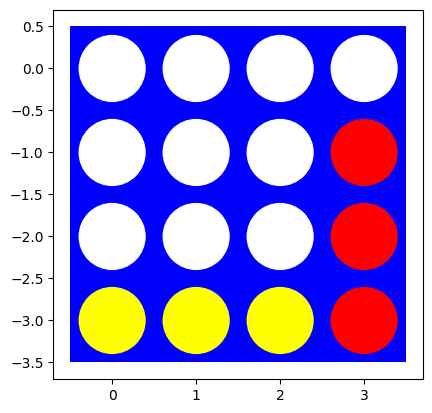

AFTER MINIMAX


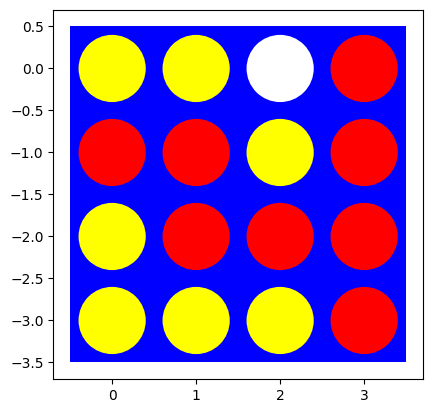

BEFORE MINIMAX


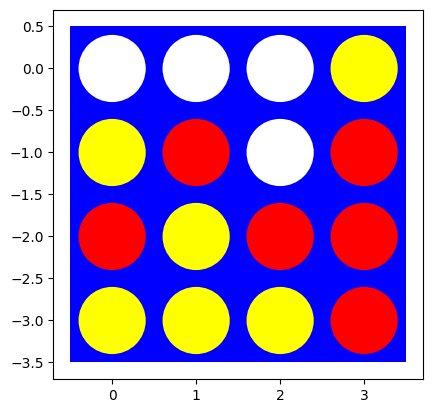

AFTER MINIMAX


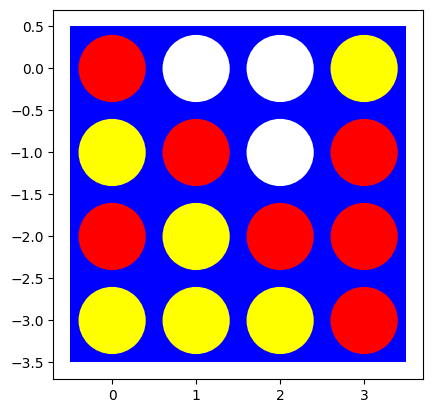

BEFORE MINIMAX


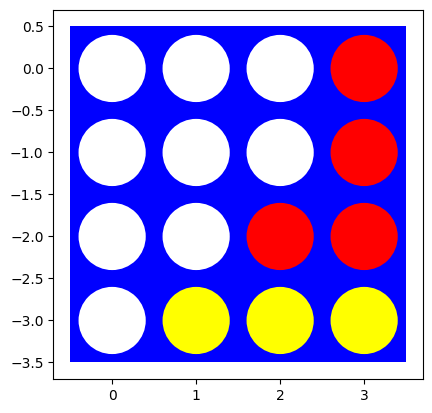

AFTER MINIMAX


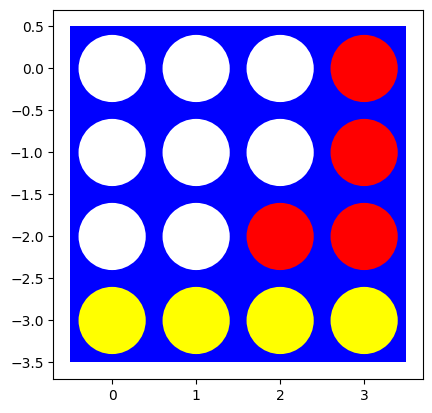

BEFORE MINIMAX


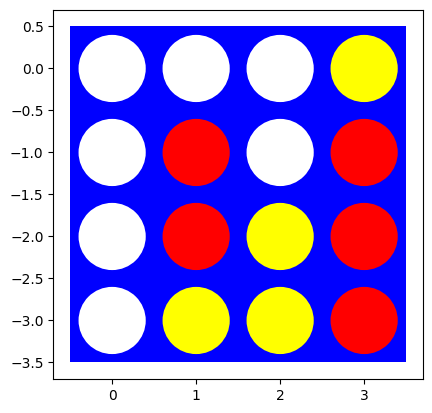

AFTER MINIMAX


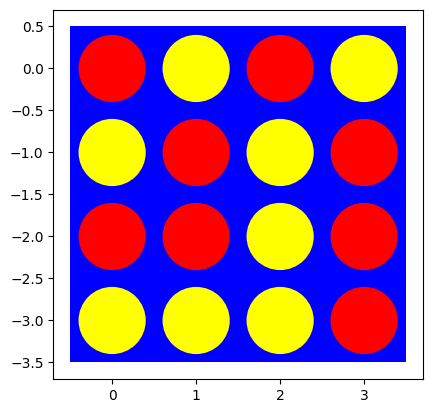

BEFORE MINIMAX


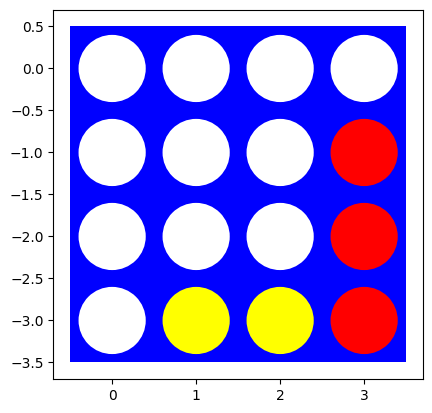

AFTER MINIMAX


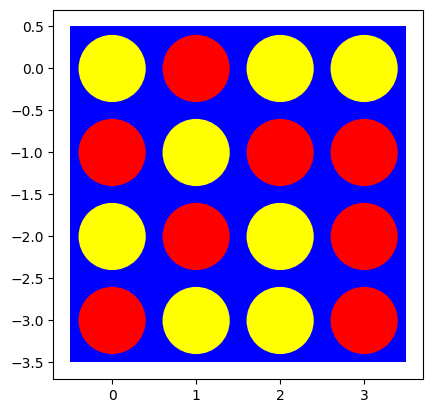

In [40]:
board1 = [[0,0,0,0],
          [0,0,0,1],
          [0,0,0,1],
          [-1,-1,-1,1]]
board2 = [[0,0,0,-1],
          [-1,1,0,1],
          [1,-1,1,1],
          [-1,-1,-1,1]]
board3 = [[0,0,0,1],
          [0,0,0,1],
          [0,0,1,1],
          [0,-1,-1,-1]]
board4 = [[0,0,0,-1],
          [0,1,0,1],
          [0,1,-1,1],
          [0,-1,-1,1]]
board5 = [[0,0,0,0],
          [0,0,0,1],
          [0,0,0,1],
          [0,-1,-1,1]]
boards = [board1,board2,board3,board4,board5]


for theBoard in boards:
    print("BEFORE MINIMAX")
    visualize(theBoard)
    print("AFTER MINIMAX")
    minimax_env(theBoard)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

It's a fairly short time to solve each of the 5 boards, roughly 1 second each for the 4 column boards. Let me try a larger board.

BEFORE


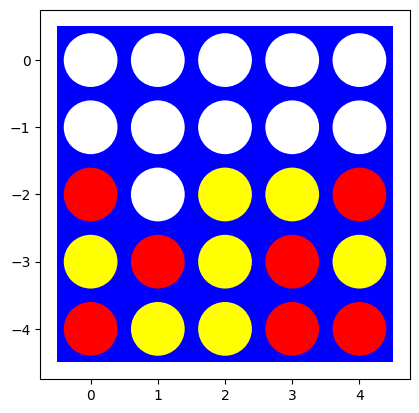

AFTER


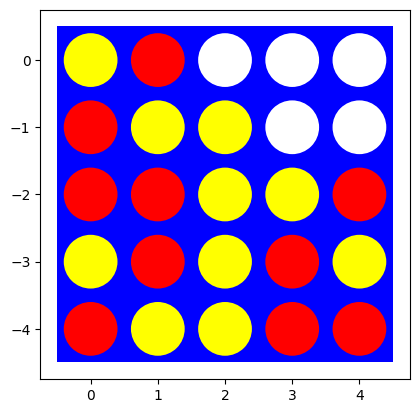

In [41]:
# Your code/ answer goes here.
board = [ [0,0,0,0,0],
          [0,0,0,0,0],
          [1,0,-1,-1,1],
          [-1,1,-1,1,-1],
          [1,-1,-1,1,1]]

print("BEFORE")
visualize(board)
print("AFTER")
minimax_env(board)

One 5x5 took 5 seconds by itself. I'll try a 6x6, I'm going to assume that it will take took long to be efficient.

BEFORE


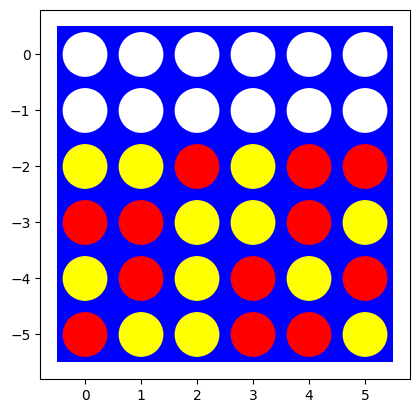

AFTER


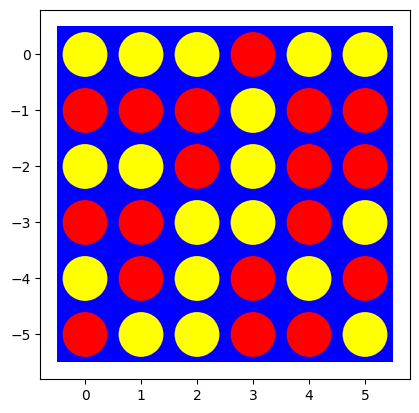

In [42]:
board = [ [0,0,0,0,0,0],
          [0,0,0,0,0,0],
          [-1,-1,1,-1,1,1],
          [1,1,-1,-1,1,-1],
          [-1,1,-1,1,-1,1],
          [1,-1,-1,1,1,-1]]

print("BEFORE")
visualize(board)
print("AFTER")
minimax_env(board)

The 6x6 took 23 seconds or so. Much too slow.

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [43]:
# Your code/ answer goes here.
def initial_moves(board,player):
    if(np.count_nonzero(board == player,axis=None) == 0 and len(board[0]) % 2 == 0):
        return {"move":0,"value":0}
    elif(np.count_nonzero(board == player,axis=None) == 0 and len(board[0]) % 2 == 1):
        return {"move":int(round(len(board[0]) / 2,0)),'value':0}
    elif(np.count_nonzero(board == player,axis=None) == 1 and len(board[0]) % 2 == 0):
        return {"move":len(board[0]) -1,'value':0}
    elif(np.count_nonzero(board == player,axis=None) == 1 and len(board[0]) % 2 == 1):
        return {'move':random.choice([int(round(len(board[0] / 2),0) - 1), int(round(len(board[0]) / 2,0) + 1)]),'value':0}
    else:
        return random.choice(HelperFunctions.get_valid_moves(board))
        
def minimax_search_optimal_first_move(board,player=None):
    global ITERATIONS
    ITERATIONS = 0
    curr_iters = 0
    if player is None:
        player = HelperFunctions.to_move(board)
    board = np.array(board)
    if(np.count_nonzero(board == player,axis=None) < 2):
        return initial_moves(board,player)
    
    
    value,move = max_value(board,player,alpha=float('-inf'),beta=float('inf'))
    # print(player)
    color = "Red"
    if player == -1: color = "Yellow"
    global DEBUG
    if DEBUG: print(f"Player: {color} | value: {value} | move:{move}")
    return {"move":move,"value":value}

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

I think just logically I would prefer to start in the dead middle of the board. In a normal board, the middle is generally the optimal choice. In a board that doesn't have a dead middle, my code should just randomly pick either the left middle or the right middle. After that, I will likely just pick another random move that is in the middle. Moves on the edges are generally not optimal, so we'll avoid those in the early stages.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [44]:
# Your code/ answer goes here.
def dynamic_env(players,theBoard=None,verbose=False):
    if theBoard is None:
        theBoard= empty_board(shape=(4,5))
    turns = 0
    # print(theBoard)
    while(HelperFunctions.check_win(theBoard) == 0):
        # visualize(theBoard)
        player = players[turns % 2]['player']
        player_move = players[turns % 2]['algo'](theBoard,player=player)
        if(verbose): print(player_move)
        theBoard = HelperFunctions.place(player_move['move'],theBoard,player=player)
        
        if(verbose):
            print(f"Turn #{turns} | algo:{players[turns%2]['algo'].__name__}")
            visualize(theBoard)
        turns +=1
    return {
        "winner":HelperFunctions.check_win(theBoard),
        "turns_taken":turns
    }
        
def dynamic_stats_env(players,num_iters = 5):
    results = []
    times = []
    for i in range(num_iters):
        print(f"Iteration #{i}")
        start = timer()
        results.append(dynamic_env(players))
        # print(results)
        end = timer()
        times.append(end - start)
    print(f"Average time taken per match: {np.mean(times)}")
    print_results(results) 
        
    
            
players = [
    {
        "algo":minimax_search_optimal_first_move,
        "player":1
     },
    {
        "algo":random_player,
        "player":-1
    }
    
]

This code takes a while, but nearly every time the minimax search wins. 

In [45]:
#dynamic_env(players,verbose=False)

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

The heuristic evaluation function (from up top) is repeated here:

```
...
            for kernel in detection_kernels:
                a = convolve2d(board, kernel, mode='valid')
                if (a == (3 * player)).any():
                    times = np.count_nonzero(a == (3 * player))
                    utils += [0.5] * times
                if (a == (2 * player)).any():
                    times = np.count_nonzero(a == (2 * player))
                    utils += [0.25] * times
                if (a == (3 * player) * -1).any():
                    times = np.count_nonzero(a == (3 * player * -1))
                    utils += [-0.5] * times
                if (a == (2 * player) * -1).any():
                    times = np.count_nonzero(a == (2 * player * -1))
                    utils += [-0.25] * times

            if len(utils) != 0:
                return HelperFunctions.sigmoid(np.sum(utils)), False
            else:
                return 0, False
    ...

```

This eval function uses numpy's convolve to look for rows of two or three and assigns proper utility ratings to each (either .5 or .25). If the opponent has these strings, the utility is negated.

### Cutting off search [10 points]

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [46]:
# Your code/ answer goes here.
class Move:
    def __init__(self,action,util):
        self.action = action
        self.util = util
    def __lt__(self,other):
        return self.util < other.util
    def __gt__(self,other):
        return self.util > other.util
    def __le__(self,other):
        return self.util <= other.util
    def __ge__(self,other):
        return self.util >= other.util
def order_actions_on_util(actions,util_func,player,board):
    # theMoves = [Move((action,util_func(HelperFunctions.place(action,board,player),player) for action in actions))]
    theMoves = [(move,util_func(HelperFunctions.place(move,board,player),player)[0] ) for move in actions]
    theMoves.sort(key = lambda x: x[1],reverse=True)
    # print(theMoves)
    return [move[0] for move in theMoves]


# order_actions_on_util(HelperFunctions.get_valid_moves(empty_board()),HelperFunctions.evaluate_board,1,empty_board())

bananna = order_actions_on_util(HelperFunctions.get_valid_moves(empty_board()),HelperFunctions.evaluate_board,1,empty_board())
print(bananna)

[0, 1, 2, 3, 4, 5, 6]


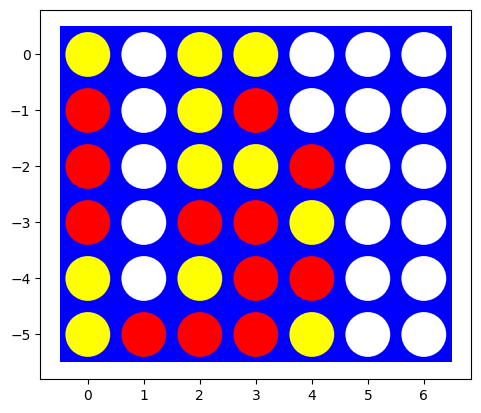

CUTOFF COUNT: 1
CUTOFF COUNT: 2
stopped at 2: [[-1  0 -1 -1  0  0  0]
 [ 1  0 -1  1  0  0  0]
 [ 1  0 -1 -1  1  0  0]
 [ 1  1  1  1 -1  0  0]
 [-1 -1 -1  1  1  0  0]
 [-1  1  1  1 -1  0  0]] term: True eval: -2 [-2, -2]
CUTOFF COUNT: 3
CUTOFF COUNT: 4
stopped at 4: [[-1  0 -1 -1 -1  0  0]
 [ 1  0 -1  1  1  0  0]
 [ 1  0 -1 -1  1  0  0]
 [ 1  1  1  1 -1  0  0]
 [-1 -1 -1  1  1  0  0]
 [-1  1  1  1 -1  0  0]] term: True eval: -2 [-2, -2]
CUTOFF COUNT: 5
CUTOFF COUNT: 6
stopped at 6: [[-1  0 -1 -1 -1  0  0]
 [ 1  0 -1  1  1  0  0]
 [ 1  1 -1 -1  1  0  0]
 [ 1 -1  1  1 -1  0  0]
 [-1 -1 -1  1  1  0  0]
 [-1  1  1  1 -1  0  1]] term: True eval: -2 [-2, -2]
CUTOFF COUNT: 7
stopped at 6: [[-1  0 -1 -1 -1  0  0]
 [ 1  0 -1  1  1  0  0]
 [ 1  0 -1 -1  1  0  0]
 [ 1 -1  1  1 -1  0  0]
 [-1 -1 -1  1  1  0  1]
 [-1  1  1  1 -1  0  1]] term: False eval: -0.12435300177159614 [-inf, -2]
CUTOFF COUNT: 8
stopped at 6: [[-1  0 -1 -1 -1  0  0]
 [ 1  0 -1  1  1  0  0]
 [ 1  0 -1 -1  1  0  0]
 [ 1 -1  1  1

In [47]:
# Your code/ answer goes here.
from IPython.display import clear_output
import json
CUTOFF_DEBUG = False
CUTOFF_COUNT = 0
def other(the_int):
    if the_int == 1:
        return -1
    else:
        return 1

def a_b_cutoff_search(board,cutoff=None,player=1,verbose=False,eval_func=HelperFunctions.evaluate_board):
    global CUTOFF_DEBUG, CUTOFF_COUNT
    CUTOFF_COUNT = 0
    CUTOFF_DEBUG = verbose
    # print('yeet')
    board = np.array(board)
    # if(np.count_nonzero(board == player,axis=None) < 2):
    #     # print('bad')
    #     return initial_moves(board,player)
    
    value,move = max_value_ab(board,player,-math.inf,+math.inf,0,cutoff,eval_func)
    
    if CUTOFF_DEBUG: print(f"Number of nodes searched (cutoff = {cutoff}): {CUTOFF_COUNT}") 
    
    return {"move": move, "value": value}
def max_value_ab(board,player,alpha,beta,depth,cutoff,eval_func):
    global CUTOFF_DEBUG, CUTOFF_COUNT
    CUTOFF_COUNT+=1
    if(CUTOFF_DEBUG): 
        print(f"CUTOFF COUNT: {CUTOFF_COUNT}")
        # visualize(board)
    v,terminal = eval_func(board,player)
    if((cutoff is not None and depth >= cutoff) or terminal):
        if(terminal):
            alpha,beta = v,v
        if CUTOFF_DEBUG : print(f"stopped at {depth}: {board} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    v, move = -math.inf, None

    actions = []
    try:
        actions = HelperFunctions.get_valid_moves(board)
        random.shuffle(actions)
    except:
        actions = HelperFunctions.get_valid_moves(board)

    actions = order_actions_on_util(actions,eval_func,player,board)
    for action in actions:
        v2,a2 = min_value_ab(HelperFunctions.place(action,board,player=player),player,alpha,beta,depth + 1,cutoff,eval_func)
        if(v2 > v):
            v,move = v2,action
            alpha = max(alpha,v)
        if v >= beta: 
            return v,move
    return v,move

def min_value_ab(board,player,alpha,beta,depth,cutoff,eval_func):
    global CUTOFF_COUNT, CUTOFF_DEBUG
    v,terminal = eval_func(board,player)
    
    if((cutoff is not None and depth >= cutoff) or terminal):
        if terminal:
            alpha,beta = v,v
        if CUTOFF_DEBUG: print(f"stopped at {depth}: {board} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    v,move = +math.inf,None
    
    actions = []
    try:
        actions = HelperFunctions.get_valid_moves(board)
        random.shuffle(actions)
    except:
        actions = HelperFunctions.get_valid_moves(board)
    actions = order_actions_on_util(actions,eval_func,player,board)
    for action in actions:
        v2,a2 = max_value_ab(HelperFunctions.place(action,board,player=other(player)),player,alpha,beta,depth+1,cutoff,eval_func)
        if v2 < v:
            v,move = v2,action
            
            beta = min(beta,v)
        if v <= alpha: 
            return v,move
    return v,move

def truly_dynamic_environment(players,size=(4,4),visual=False,board=None):
    result = {}
    if board is None:
        board = empty_board(shape=size)
    turn_num = 0
    result['algo_info'] = {
        players[0]['algo'].__name__:{'time':[]},
        players[1]['algo'].__name__:{'time':[]}
        }
    result['algo_info']
    past_boards = []
    while(HelperFunctions.check_win(board) == 0): #While there is not a winner yet (0 does not mean draw in this case, it means non terminal state)
        player_turn = turn_num % 2
        
        start = timer()
        choice = players[player_turn]['algo'](board,**players[player_turn]['args'])['move']
        end = timer()
        board = HelperFunctions.place(choice,board,player=players[player_turn]['player'])
        if visual: 
            print(f"Utility for {players[player_turn]['algo'].__name__}: {HelperFunctions.evaluate_board(board,player=player_turn)}")
            visualize(board)
            clear_output(wait=True)
        result['algo_info'][players[player_turn]['algo'].__name__]['time'].append((end - start) * 1000)
        past_boards.append(board)
        turn_num += 1
    result['winner'] = HelperFunctions.check_win(board)
    result['turns_taken'] = turn_num
    
    return result,board,past_boards
        
        
    
# def test(a, b, c = 5):
#     print(a + b + c)
    
# def test_2():
#     print(5)

playerz = [
    {
        "algo":a_b_cutoff_search,
        "player":1,
        "args":{
            'cutoff':5,
            'verbose':False
        }
    },
    {
        "algo":random_player,
        "player":-1,
        "args":{}
    }
]

# result,final_board,board_states = truly_dynamic_environment(playerz,size=(6,7))

board = [
    [-1,  0, -1, -1,  0,  0,  0],
    [ 1,  0, -1,  1,  0,  0,  0,],
    [ 1,  0, -1, -1,  1,  0,  0,],
    [ 1,  0,  1,  1, -1,  0,  0],
    [-1,  0, -1,  1,  1, 0,  0],
    [-1,  1,  1,  1, -1,  0,  0]

]
visualize(board)

print(a_b_cutoff_search(board,cutoff=6,player=-1,verbose=True))
# print(json.dumps(result, indent=4, sort_keys=True))
# board = [[-1,0,0,0,0,0],
#          [1,0,0,0,0,0],
#          [1,0,0,0,0,1],
#          [1,1,-1,1,-1,1]]
# print(result)
# print(HelperFunctions.place(0,board,1))
   
    
# print(a_b_cutoff_search(board,verbose=True,cutoff=5))

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

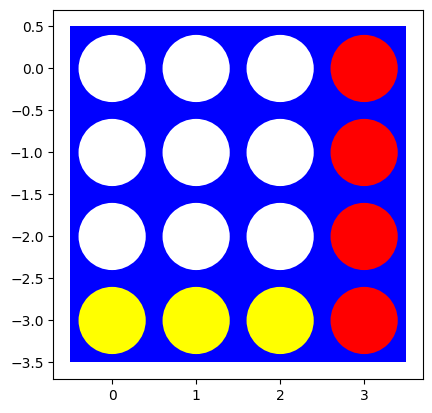

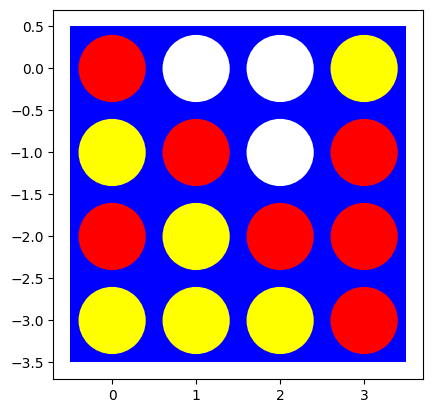

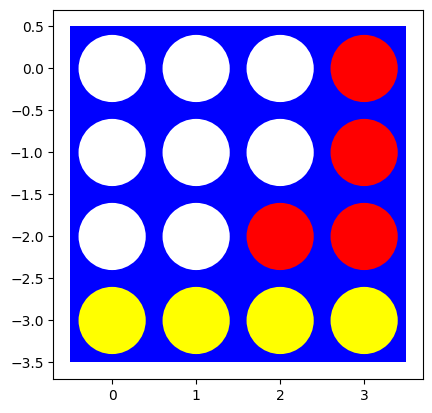

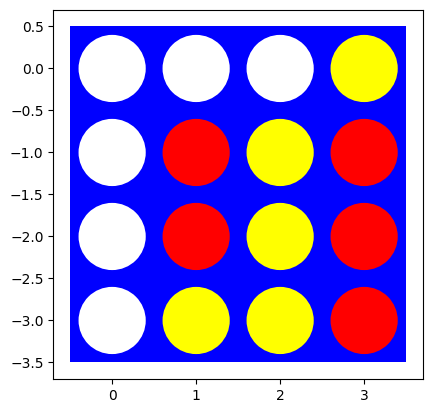

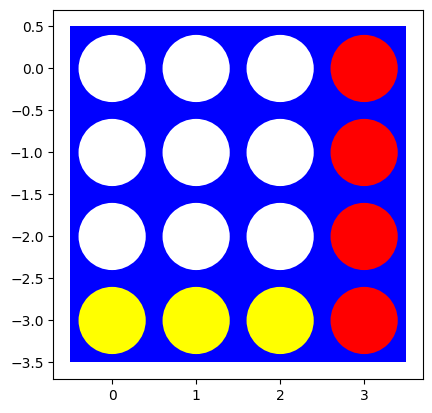

In [48]:
# Your code/ answer goes here.
board1 = [[0,0,0,0],
          [0,0,0,1],
          [0,0,0,1],
          [-1,-1,-1,1]]
board2 = [[0,0,0,-1],
          [-1,1,0,1],
          [1,-1,1,1],
          [-1,-1,-1,1]]
board3 = [[0,0,0,1],
          [0,0,0,1],
          [0,0,1,1],
          [0,-1,-1,-1]]
board4 = [[0,0,0,-1],
          [0,1,0,1],
          [0,1,-1,1],
          [0,-1,-1,1]]
board5 = [[0,0,0,0],
          [0,0,0,1],
          [0,0,0,1],
          [-1,-1,-1,1]]
boards = [board1,board2,board3,board4,board5]

# minimax_env(board1,verbose=True)

for theBoard in boards:
    visualize(HelperFunctions.place(a_b_cutoff_search(theBoard)['move'],theBoard))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

It took about 2 seconds for all of the boards, which is much faster than the minimax searching without the pruning. Adding another column is as follows:

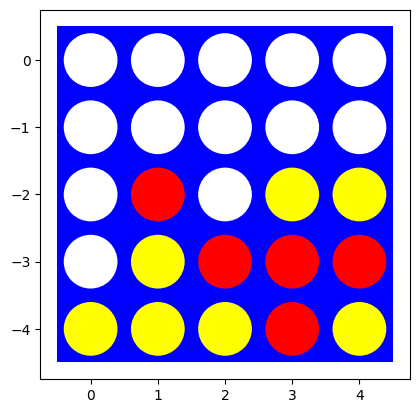

In [49]:
board = [[0,0,0,0,0],
        [0,0,0,0,0],
          [0,0,0,-1,-1],
          [0,-1,1,1,1],
          [-1,-1,-1,1,-1]]

visualize(HelperFunctions.place(a_b_cutoff_search(board)['move'],board))

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

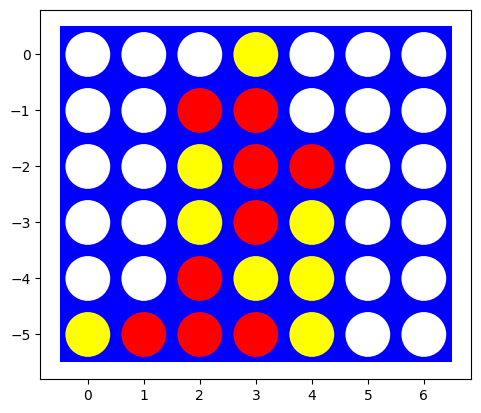

In [50]:
# Your code/ answer goes here.
playerz = [
    {
        "algo":a_b_cutoff_search,
        "player":1,
        "args":{
            'cutoff':8,
            'verbose':False
        }
    },
    {
        "algo":a_b_cutoff_search,
        "player":-1,
        "args":{
            'cutoff':3,
            'verbose':False
        }
    }
]

result,final_board,all_boards = truly_dynamic_environment(playerz,size=(6,7),visual=True)

visualize(final_board)
# print(json.dumps(result, indent=4, sort_keys=True))

## Challenge task [+ 10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

### I want to be able to play my bot. So here's some code so I can play against the bot.

In [51]:
def play_game():
    board = np.zeros((6, 7), dtype=int)  # Create an empty board
    Helper = HelperFunctions()  # Instantiate the HelperFunctions class

    visualize(board)
    
    while True:
        while True:
            try:
                user_move = int(input("Enter your move (0-6): "))
                if user_move < 0 or user_move > 6:
                    raise ValueError("Invalid move. Enter a number between 0 and 6.")
                if board[0][user_move] != 0:
                    raise ValueError("Column is full. Choose another column.")
                break
            except ValueError as ve:
                print(ve)
        
        # Update the board with the user's move
        for row in reversed(board):
            if row[user_move] == 0:
                row[user_move] = 1  # User represented by 1
                break
        
        clear_output()
        visualize(board)
        
        # Check for user's win or draw
        win_status = Helper.check_win(board)
        if win_status == 1:
            print("Congratulations! You win!")
            break
        elif win_status == -1:
            print("Sorry! You lost. The agent wins!")
            break
        elif win_status is None:
            print("It's a draw!")
            break
        
        # Agent's move (Replace this logic with the agent's move)
        agent_move = a_b_cutoff_search(board, cutoff=5, player=-1, verbose=False)['move']
        
        # Update the board with the agent's move
        for row in reversed(board):
            if row[agent_move] == 0:
                row[agent_move] = -1  # Agent represented by -1
                break
        
        clear_output()
        visualize(board)
        
        # Check for agent's win or draw
        win_status = Helper.check_win(board)
        if win_status == 1:
            print("Congratulations! You win!")
            break
        elif win_status == -1:
            print("You lose! The agent wins!")
            break
        elif win_status is None:
            print("It's a draw!")
            break


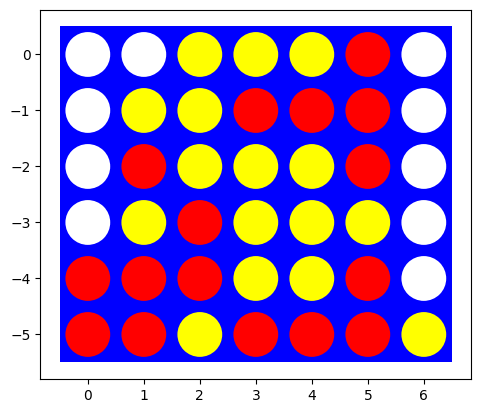

You lose! The agent wins!


In [53]:
# Start the game
play_game()

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+10 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

In [20]:
# Your code/ answer goes here.

### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [21]:
# Your code/ answer goes here.